# Customer Churn Prediction

## 1. Setup

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm shap lime flask plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=287f112bbed15e3145d5fabc87416d715e63dfb206e0756943c3b9105ace5dcd
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


## 2. Load Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Telco_customer_churn.xlsx to Telco_customer_churn (2).xlsx


In [ ]:
import pandas as pd

df = pd.read_excel(list(uploaded.keys())[0])
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## 2. Data Preprocessing

In [ ]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())
print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe().T)

print("\nUnique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Shape: (7043, 33)

Columns: ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason']

First 5 rows:
    CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

            

In [ ]:
import pandas as pd

df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

In [ ]:
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64


In [ ]:
df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)
df['Churn Reason'].fillna('No Churn', inplace=True)

/tmp/ipython-input-2791859046.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)
/tmp/ipython-input-2791859046.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [ ]:
drop_cols = [
    'CustomerID', 'Count', 'Zip Code', 'Lat Long', 'Churn Label', 'Churn Score', 'Country', 'State','Latitude', 'Longitude'

]
# Country = UnitedStates, State = California
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

print("Remaining columns after cleaning:\n", df.columns.tolist())

Remaining columns after cleaning:
 ['City', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value', 'CLTV', 'Churn Reason']


In [ ]:
df.head()

,City,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,CLTV,Churn Reason
0,Los Angeles,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,3239,Competitor made better offer
1,Los Angeles,Female,No,No,Yes,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2701,Moved
2,Los Angeles,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,5372,Moved
3,Los Angeles,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,5003,Moved
4,Los Angeles,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,5340,Competitor had better devices


In [ ]:
# Save as CSV
df.to_csv("my_data.csv", index=False)

# Download in local machine
from google.colab import files
files.download("my_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. EDA

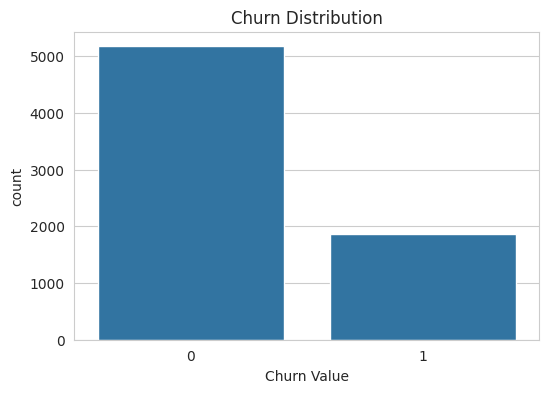

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Churn Value', data=df)
plt.title("Churn Distribution")
plt.show()

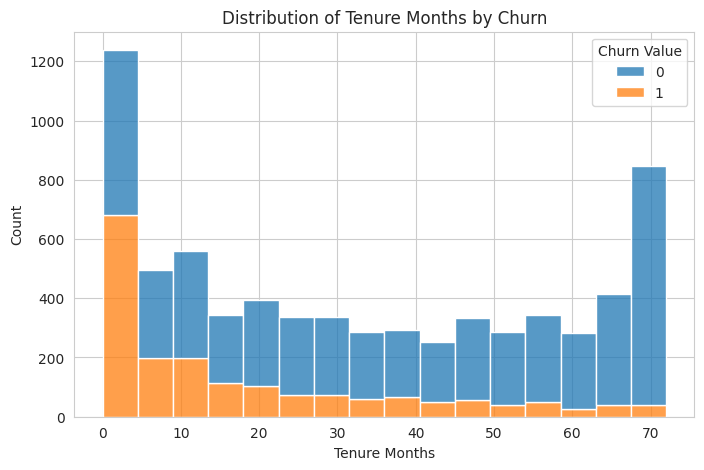

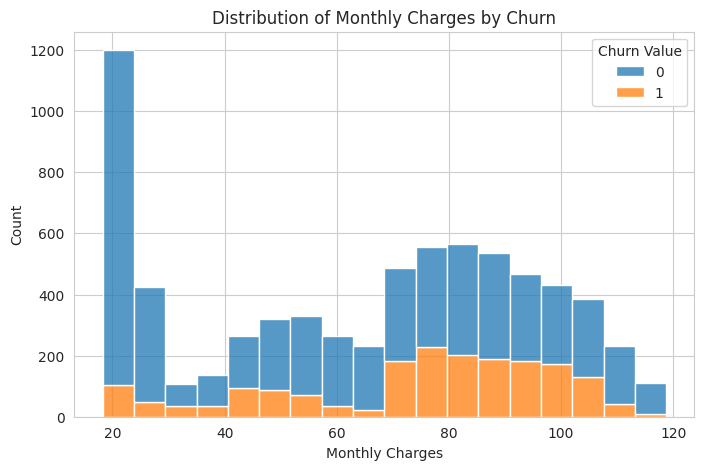

In [ ]:
target = 'Churn Value'
num_features = ['Tenure Months', 'Monthly Charges']

for col in num_features:
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x=col, hue=target, multiple='stack', kde=False)
    plt.title(f"Distribution of {col} by Churn")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

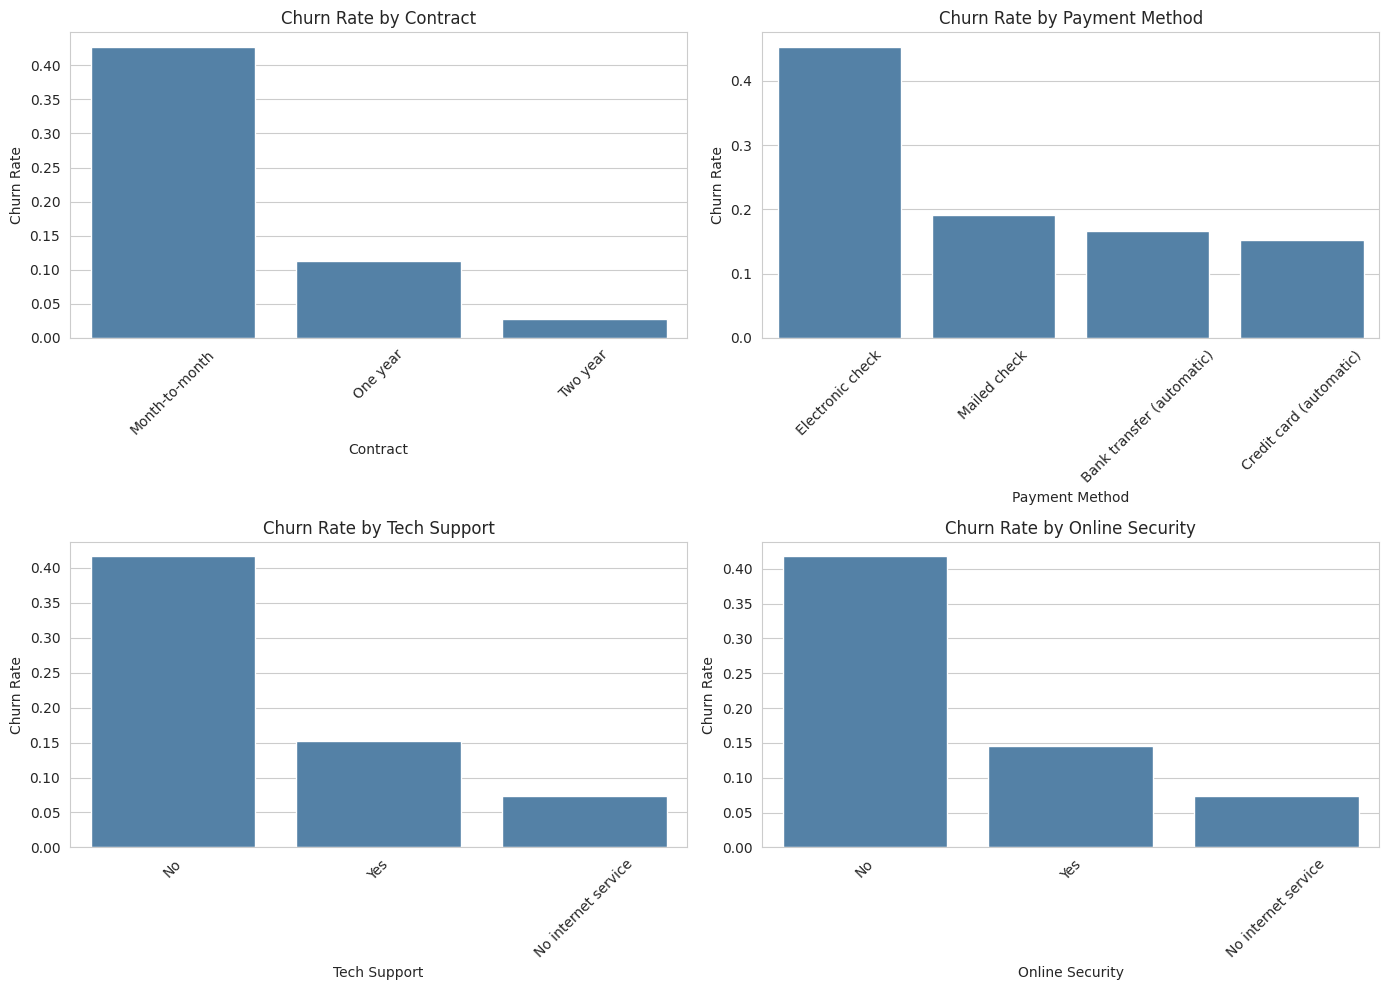

In [ ]:
target = "Churn Value"
cat_features = ['Contract', 'Payment Method', 'Tech Support', 'Online Security']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    churn_rate = df.groupby(col)[target].mean().sort_values(ascending=False)

    sns.barplot(
        x=churn_rate.index,
        y=churn_rate.values,
        color="steelblue",
        ax=axes[i]
    )

    axes[i].set_title(f"Churn Rate by {col}", fontsize=12)
    axes[i].set_ylabel("Churn Rate")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

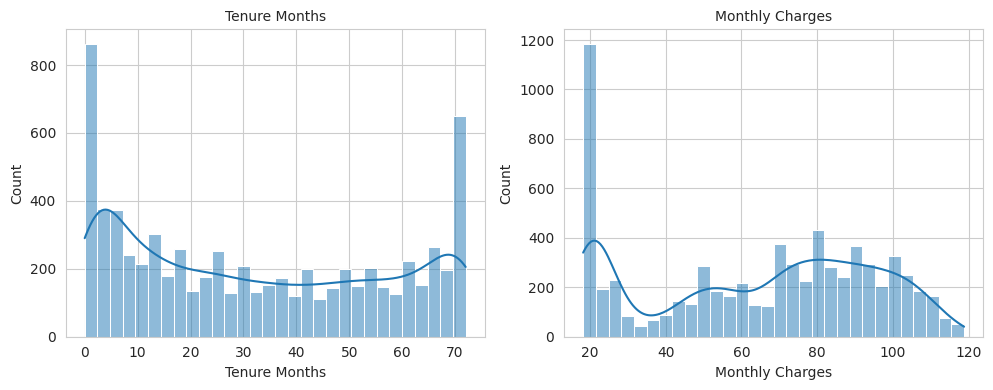

In [ ]:
import math

numeric_cols = ['Tenure Months', 'Monthly Charges']
n_cols_per_row = 4
n_rows = math.ceil(len(numeric_cols) / n_cols_per_row)

plt.figure(figsize=(20, n_rows*4))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols_per_row, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()

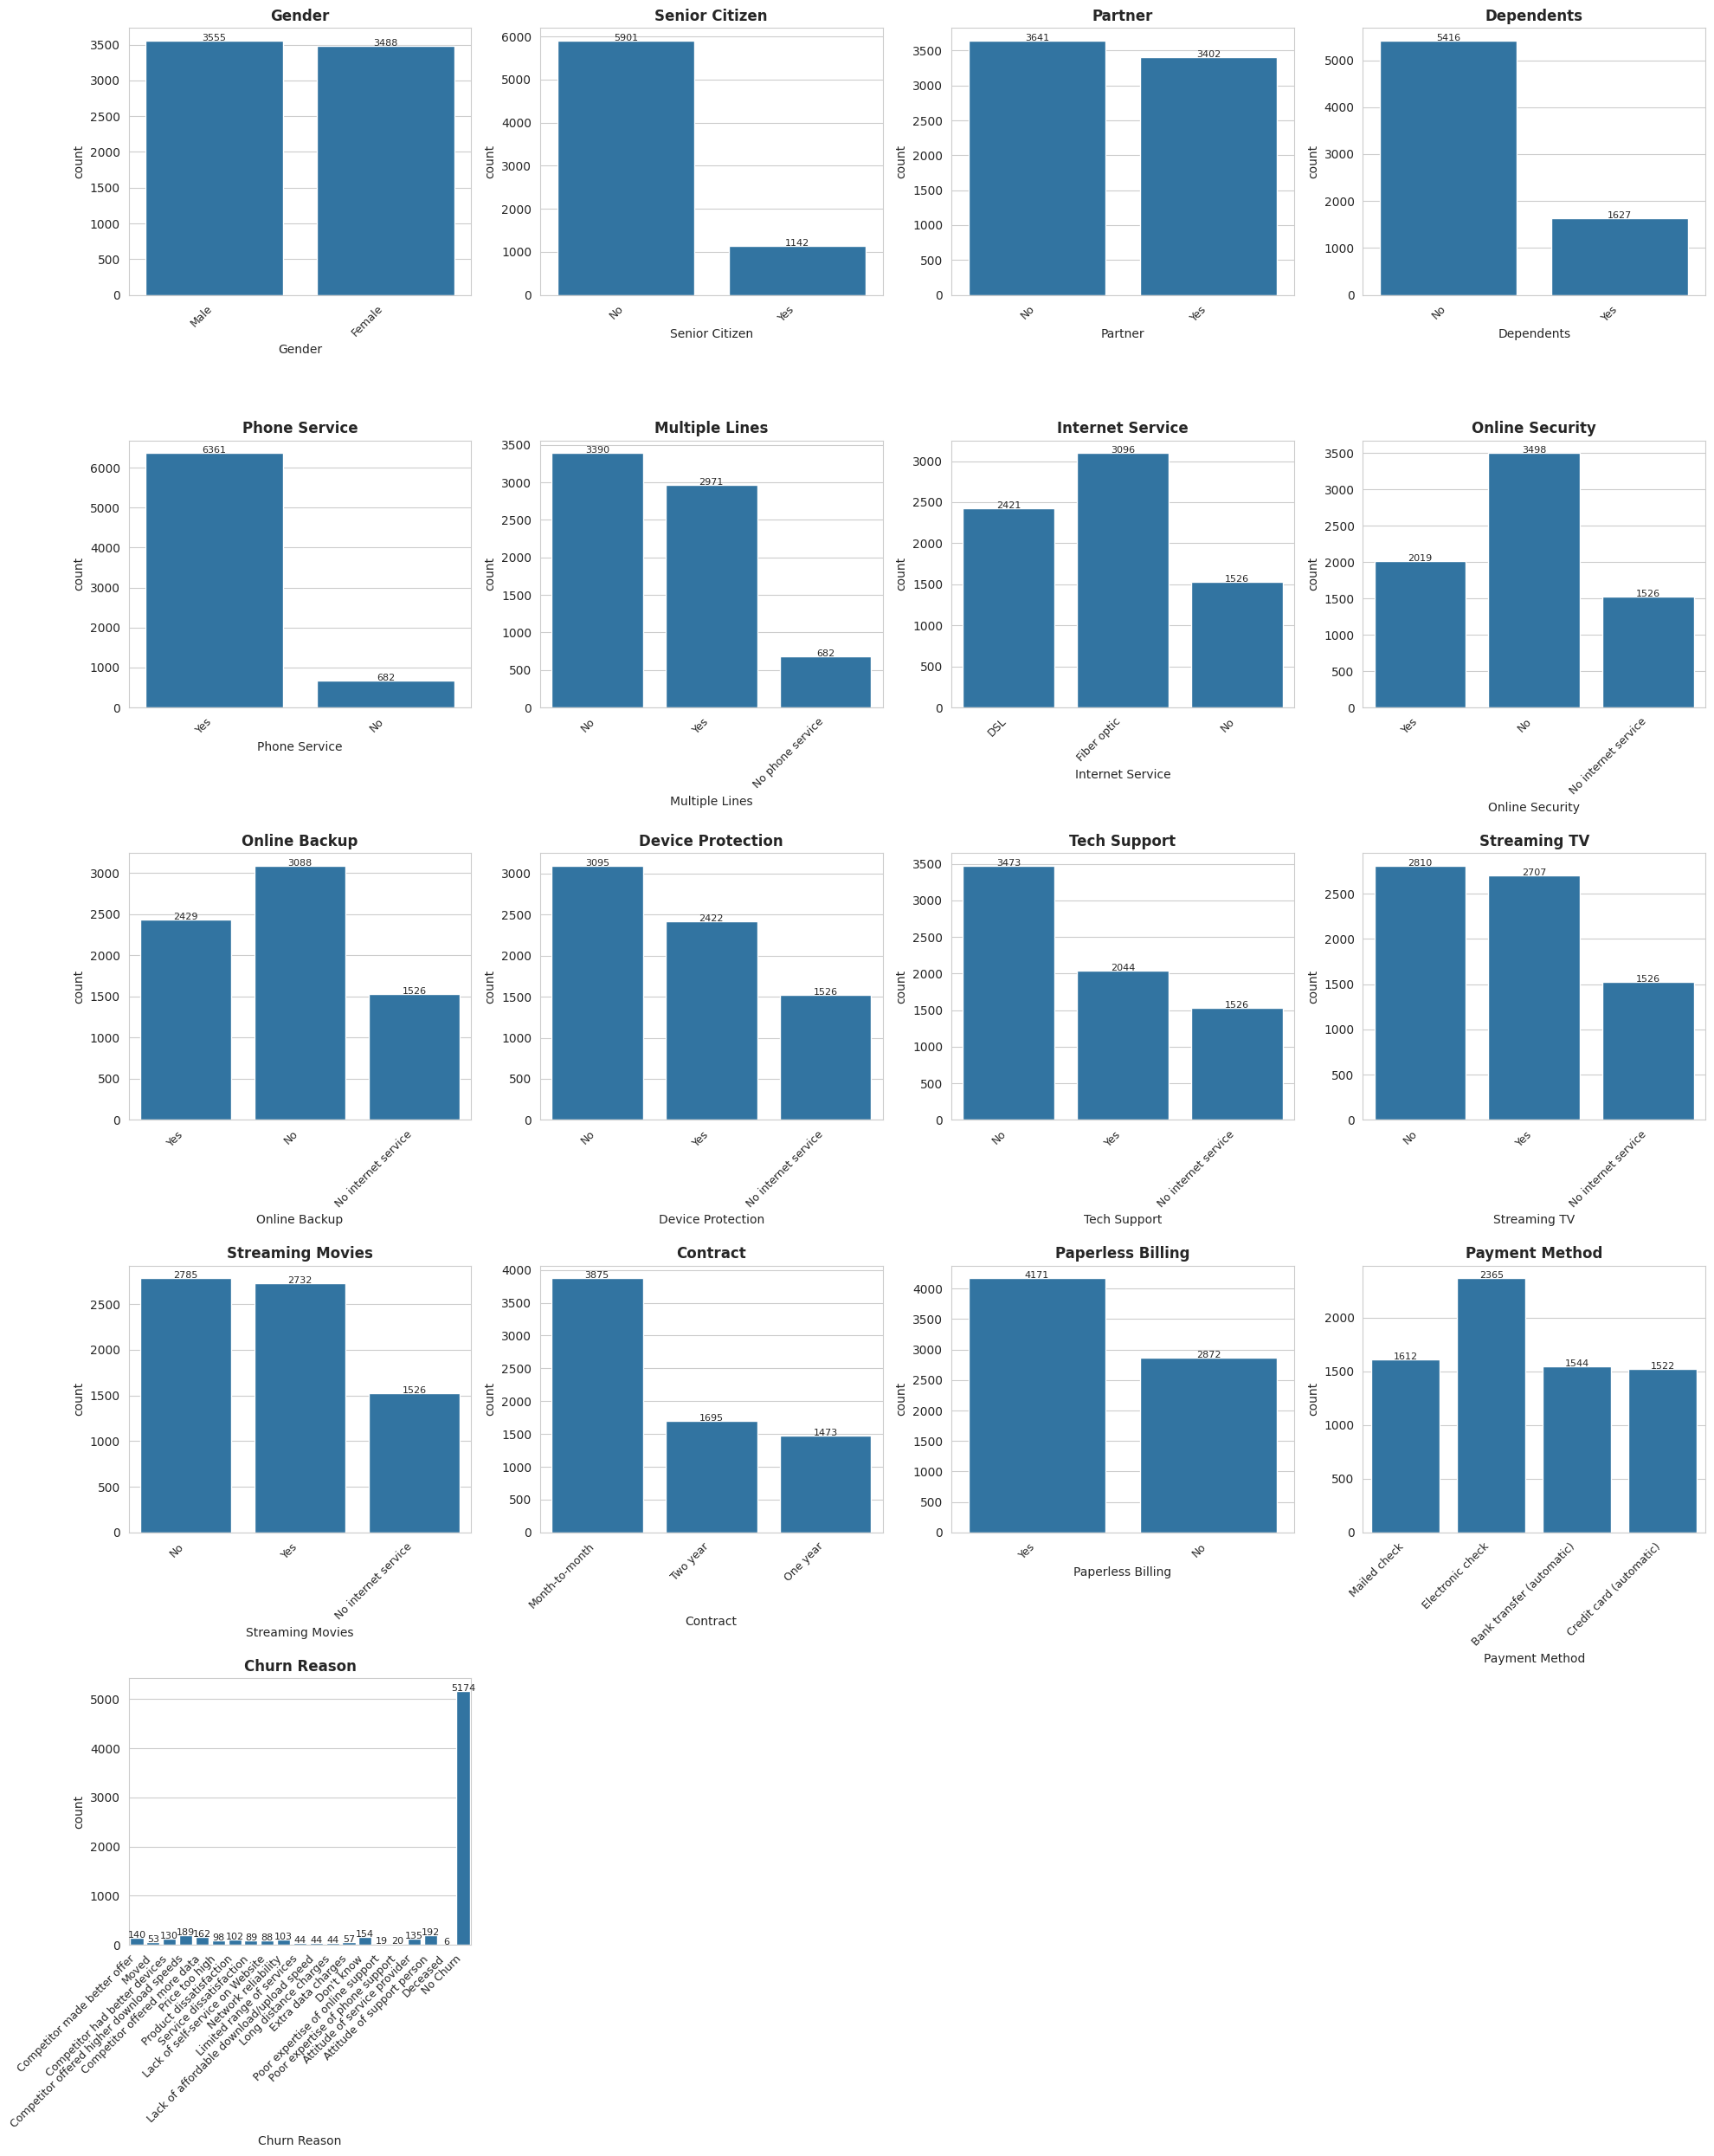

In [ ]:
sns.set_style("whitegrid")

categorical_cols = [
    'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
    'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup',
    'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
    'Contract', 'Paperless Billing', 'Payment Method', 'Churn Reason'
]

n_cols_per_row = 4
n_rows = math.ceil(len(categorical_cols) / n_cols_per_row)
plt.figure(figsize=(20, n_rows*5))

for i, col in enumerate(categorical_cols):
    plt.subplot(n_rows, n_cols_per_row, i+1)

    ax = sns.countplot(
        x=col,
        data=df
    )

    plt.title(col, fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=9)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.5, int(height), ha="center", fontsize=8)

plt.tight_layout()
plt.show()


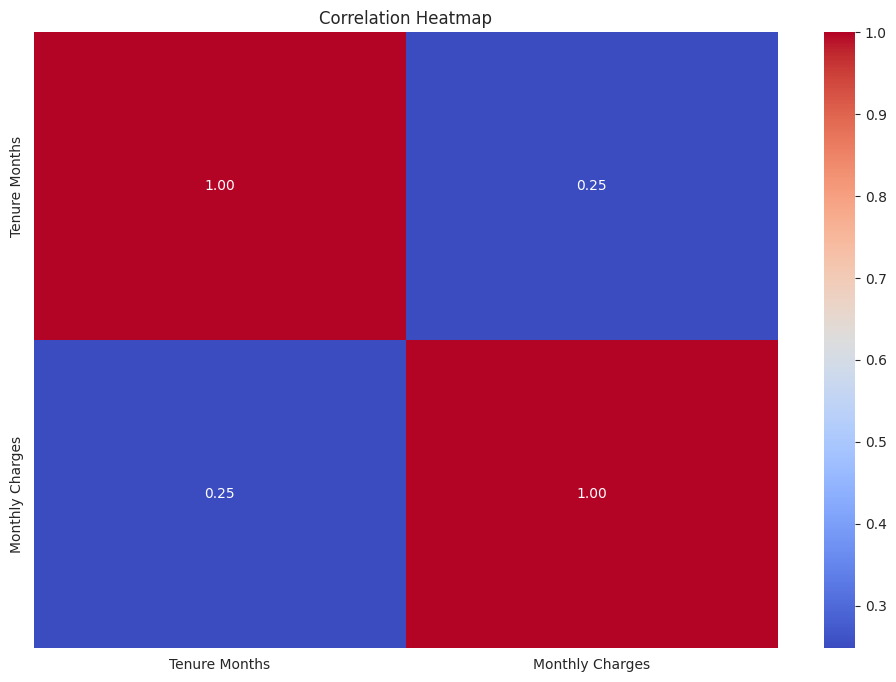

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

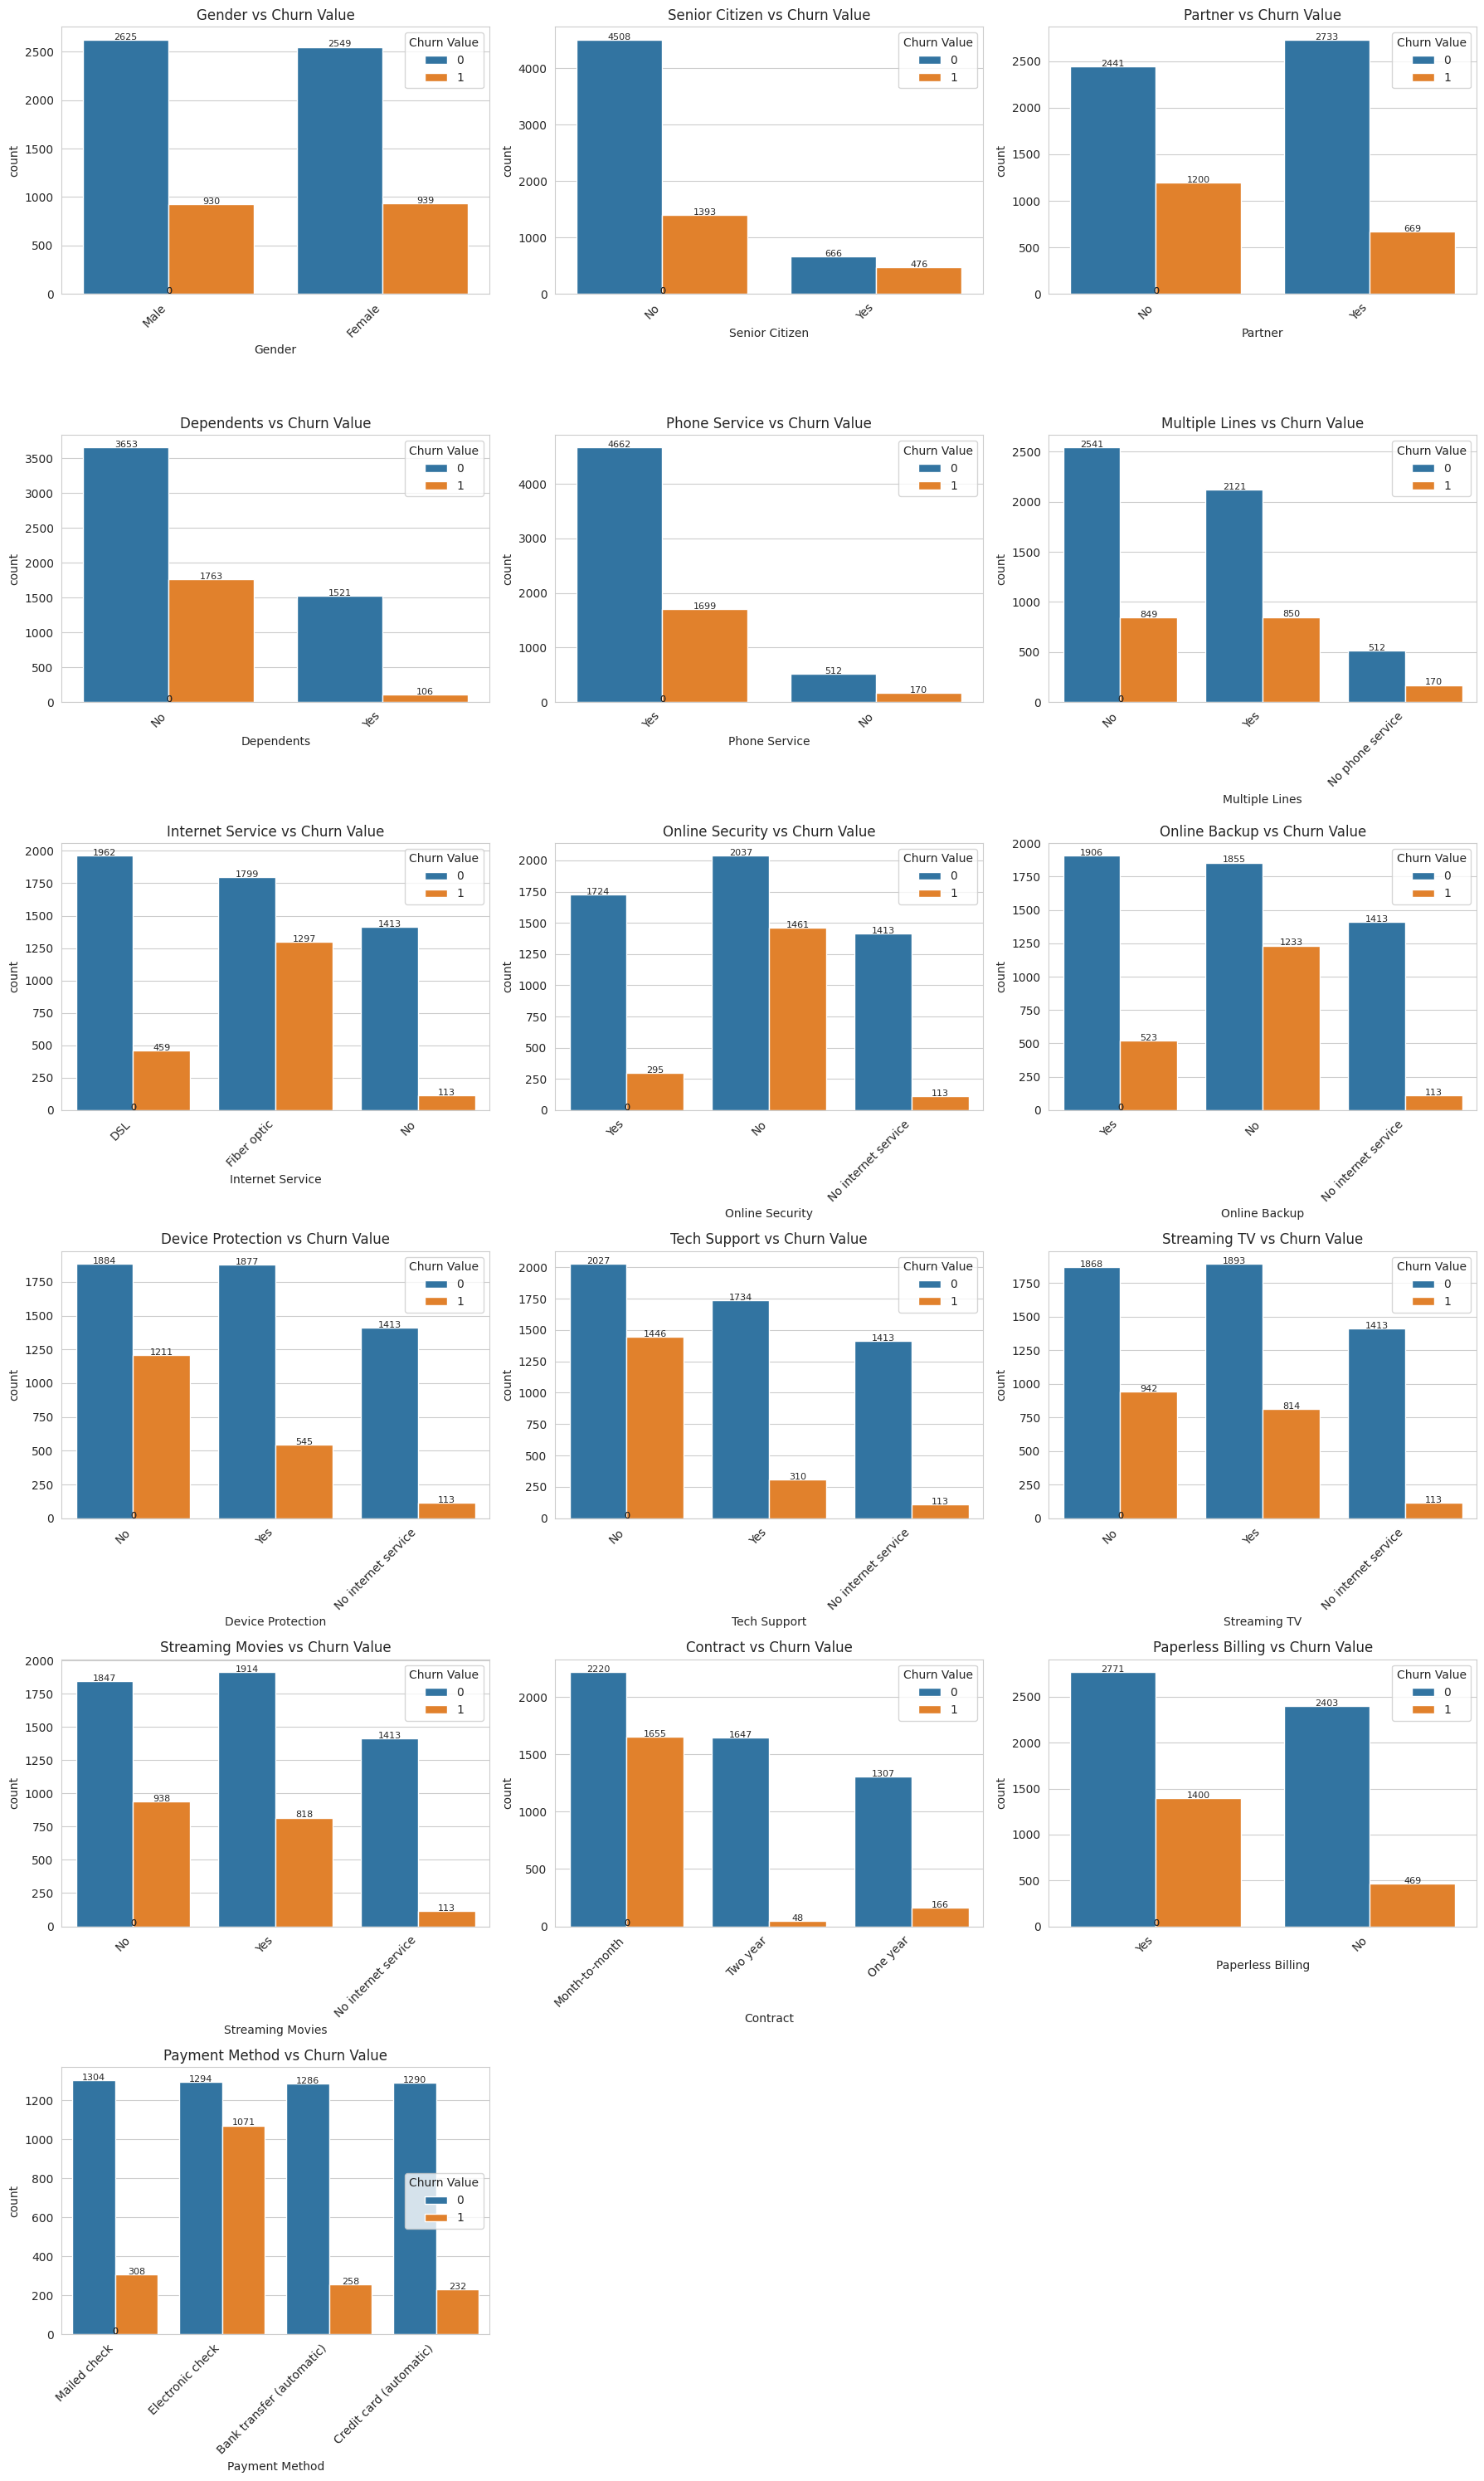

In [ ]:
target_col = 'Churn Value'
cat_cols_to_plot = [col for col in categorical_cols if col not in [target_col, 'Churn Reason']]
n_cols = 3
n_rows = math.ceil(len(cat_cols_to_plot)/n_cols)
plt.figure(figsize=(18,n_rows*5))

for i, col in enumerate(cat_cols_to_plot):
    plt.subplot(n_rows, n_cols, i+1)
    ax = sns.countplot(x=col, hue=target_col, data=df)
    plt.title(f"{col} vs {target_col}")
    plt.xticks(rotation=45, ha='right')
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.5, int(height), ha="center", fontsize=8)
plt.tight_layout()
plt.show()

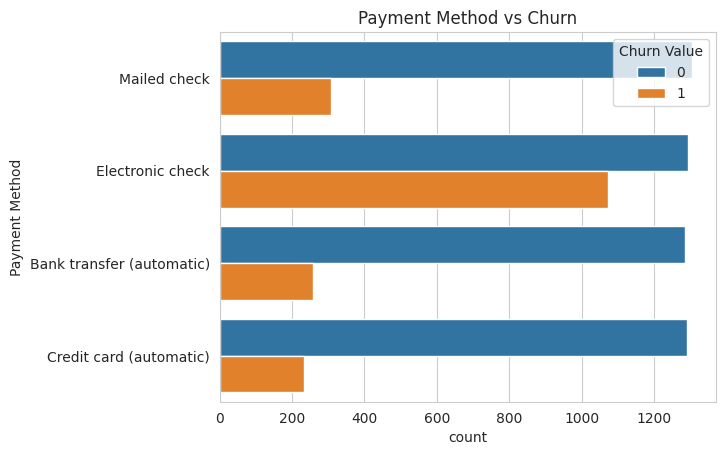

In [ ]:
sns.countplot(y="Payment Method", hue="Churn Value", data=df)
plt.title("Payment Method vs Churn")
plt.show()

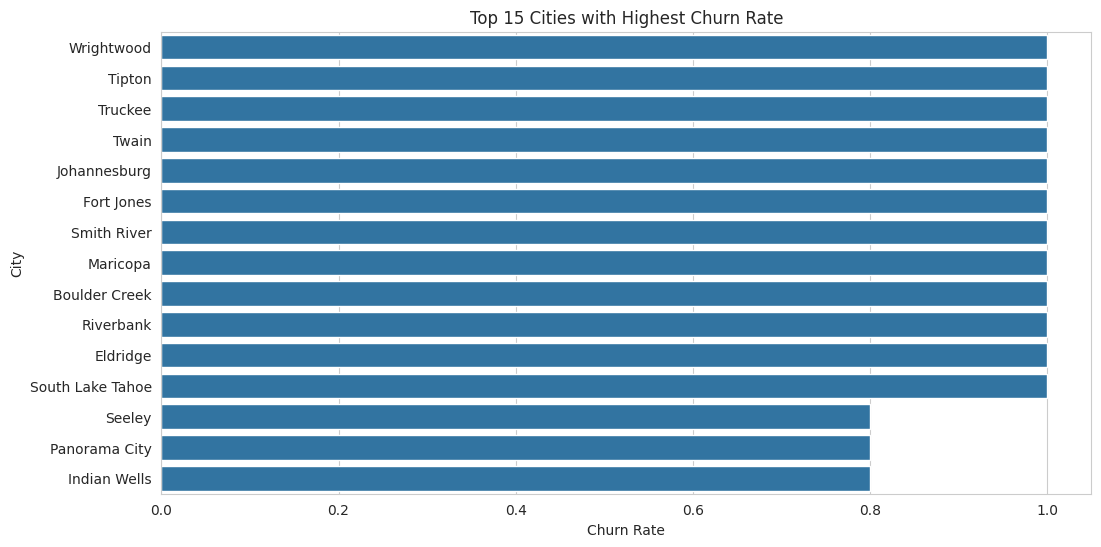

In [ ]:
# City wise churn rate
city_churn = df.groupby("City")["Churn Value"].mean().reset_index()
city_churn = city_churn.sort_values(by="Churn Value", ascending=False)

# Top 15 cities with highest churn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(y="City", x="Churn Value", data=city_churn.head(15))
plt.title("Top 15 Cities with Highest Churn Rate")
plt.xlabel("Churn Rate")
plt.ylabel("City")
plt.show()


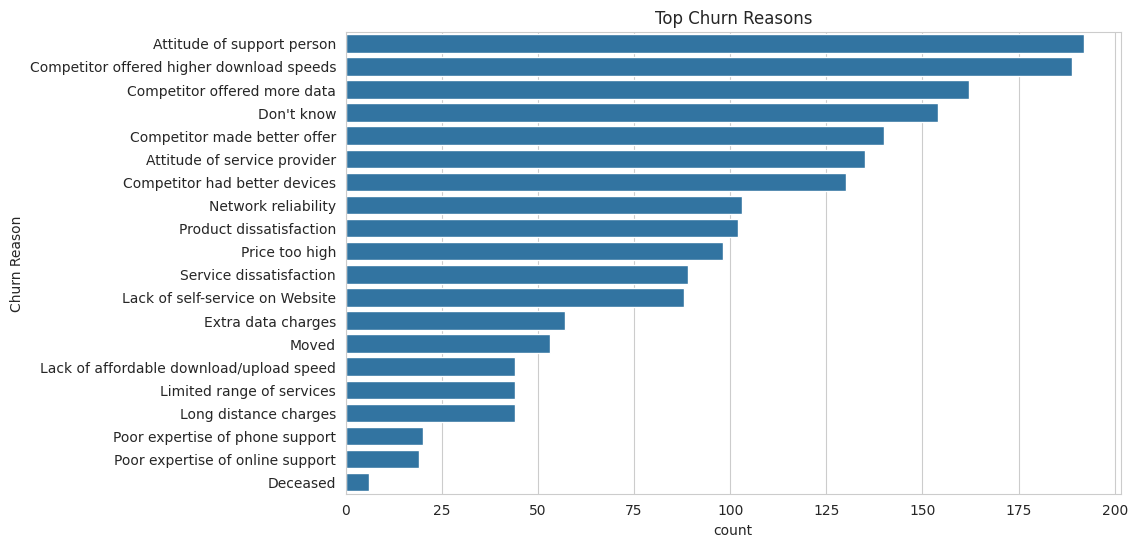

In [ ]:
# Churn Reason frequency (only churned customers)
churned = df[df["Churn Value"]==1]
plt.figure(figsize=(10,6))
sns.countplot(y="Churn Reason", data=churned, order=churned["Churn Reason"].value_counts().index)
plt.title("Top Churn Reasons")
plt.show()

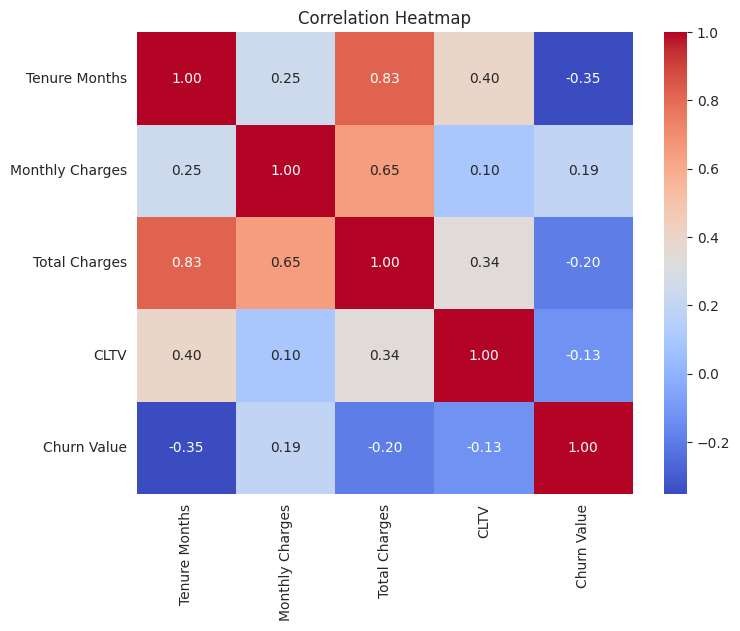

In [ ]:
for col in ["Tenure Months", "Monthly Charges", "Total Charges", "CLTV"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

numeric_cols = ["Tenure Months", "Monthly Charges", "Total Charges", "CLTV", "Churn Value"]

plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
from google.colab import files

df.to_csv("churn_data.csv", index=False)
files.download("churn_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.columns

Index(['City', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'CLTV', 'Churn Reason'],
      dtype='object')

In [ ]:
df = df.drop('City', axis = 1)
df = df.drop('Churn Reason', axis = 1)

print("Remaining columns after cleaning:\n", df.columns.tolist())

Remaining columns after cleaning:
 ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value', 'CLTV']


## 4. Feature Engineering

### 4.1 Feature Creation

In [ ]:
df.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,CLTV
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,3239
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2701
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,5372
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,5003
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,5340


In [ ]:
def tenure_category(months):
    if months <= 12:
        return 'Short'
    elif months <= 36:
        return 'Mid'
    else:
        return 'Long'

df['Tenure Category'] = df['Tenure Months'].apply(tenure_category)
df['Cost_per_Month'] = df['Total Charges'] / (df['Tenure Months'] + 1)
df['Secure_Contract'] = ((df['Contract'] != 'Month-to-month') &
                         (df['Online Security'] == 'Yes')).astype(int)

### 4.2 Feature Selection

In [ ]:
df.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'CLTV', 'Tenure Category', 'Cost_per_Month', 'Secure_Contract'],
      dtype='object')

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

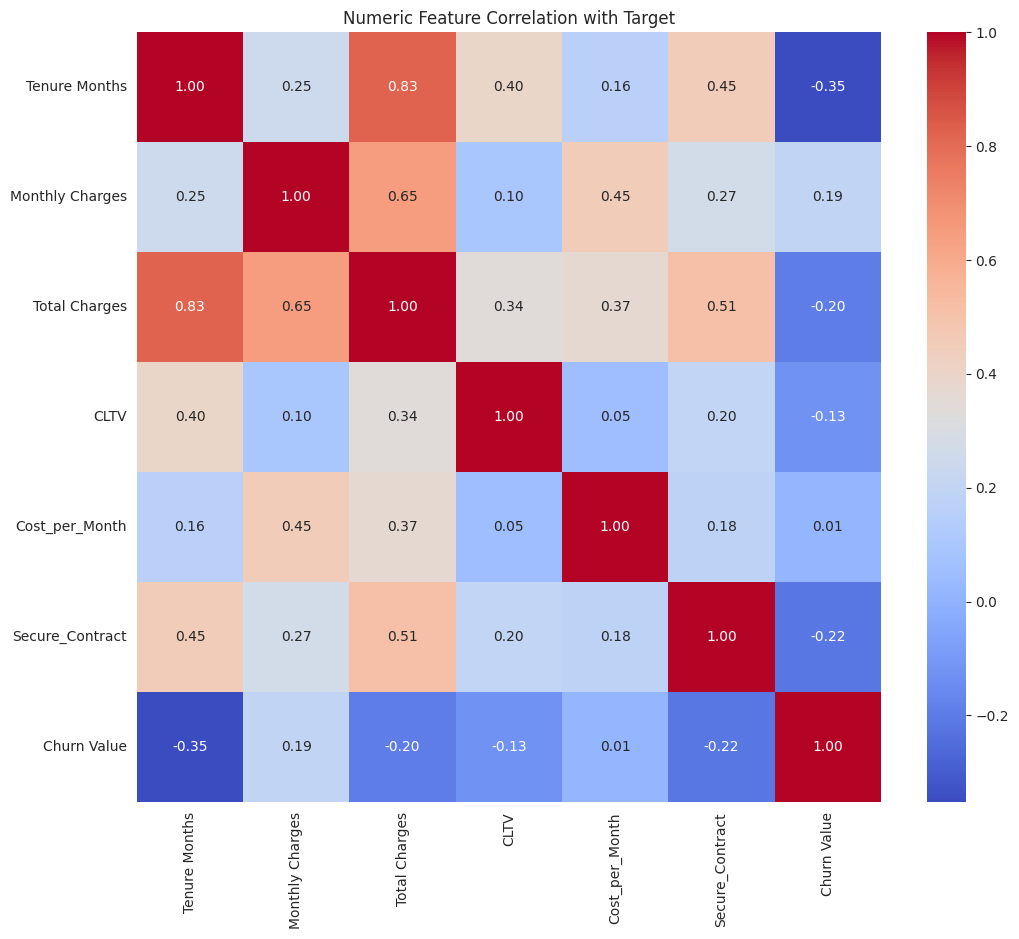

Highly correlated features (abs(corr) > 0.1):
 ['Tenure Months', 'Secure_Contract', 'Total Charges', 'Monthly Charges', 'CLTV']


In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

if target_col in numeric_cols:
    numeric_cols.remove(target_col)

corr_matrix = df[numeric_cols + [target_col]].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Numeric Feature Correlation with Target')
plt.show()

high_corr_features = corr_matrix[target_col].abs().sort_values(ascending=False)
high_corr_features = high_corr_features[high_corr_features > 0.1].index.tolist()

if target_col in high_corr_features:
    high_corr_features.remove(target_col)

print("Highly correlated features (abs(corr) > 0.1):\n", high_corr_features)


Mutual Information Scores (Categorical features):
 Contract             0.098453
Online Security      0.064677
Tech Support         0.063021
Tenure Category      0.058395
Internet Service     0.055574
Online Backup        0.046792
Payment Method       0.044519
Device Protection    0.043917
Dependents           0.037746
Streaming Movies     0.032001
Streaming TV         0.031908
Paperless Billing    0.019194
Partner              0.011454
Senior Citizen       0.010577
Multiple Lines       0.000801
Phone Service        0.000072
Gender               0.000037
dtype: float64


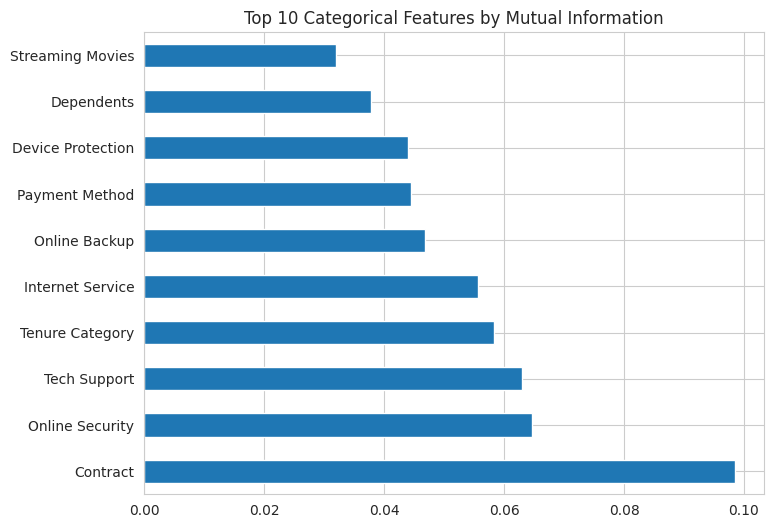

In [ ]:
# Categorical Features
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if target_col in categorical_cols:
    categorical_cols.remove(target_col)

if categorical_cols:
    df_encoded = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))

    mi = mutual_info_classif(df_encoded, df[target_col],
                             discrete_features=True, random_state=42)

    mi_scores = pd.Series(mi, index=categorical_cols).sort_values(ascending=False)

    print("\nMutual Information Scores (Categorical features):\n", mi_scores)
    mi_scores.head(10).plot(kind='barh', figsize=(8, 6))
    plt.title("Top 10 Categorical Features by Mutual Information")
    plt.show()
else:
    print("\nNo categorical features available for MI analysis.")


Top 15 Features by Random Forest Importance:
 Total Charges        0.122027
Monthly Charges      0.118188
Cost_per_Month       0.113897
CLTV                 0.108587
Tenure Months        0.103813
Contract             0.067746
Tech Support         0.038742
Online Security      0.038685
Payment Method       0.037336
Dependents           0.032097
Tenure Category      0.029436
Internet Service     0.024275
Online Backup        0.021378
Paperless Billing    0.019832
Gender               0.019790
dtype: float64


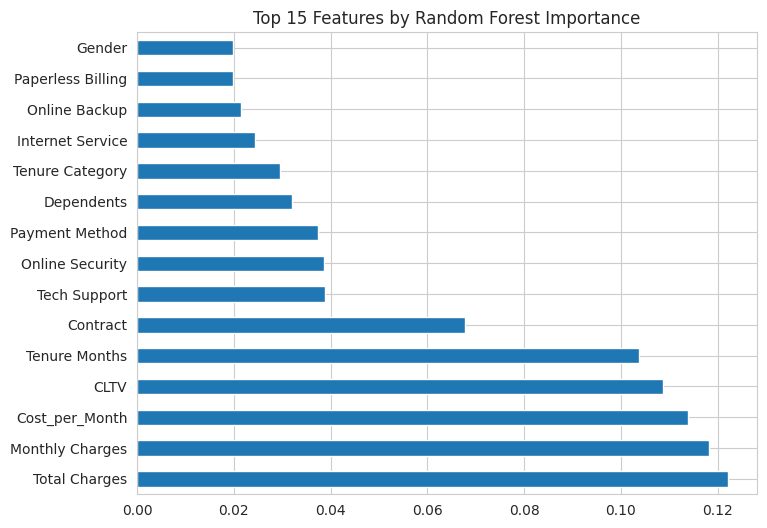

In [ ]:
# Top 15 Features by Random Forest Importance
X = df[numeric_cols + categorical_cols].copy()
y = df[target_col]

for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

print("\nTop 15 Features by Random Forest Importance:\n", feat_importances.head(15))

feat_importances.head(15).plot(kind='barh', figsize=(8, 6))
plt.title("Top 15 Features by Random Forest Importance")
plt.show()

In [ ]:
combined_features = set(high_corr_features) | set(mi_scores.head(15).index) | set(feat_importances.head(15).index)

final_selected_features = [col for col in combined_features]
print("\nFinal Selected Features for Model Training (Leakage-Free):\n", final_selected_features)


Final Selected Features for Model Training (Leakage-Free):
 ['Tech Support', 'Tenure Months', 'Multiple Lines', 'Cost_per_Month', 'Online Backup', 'Dependents', 'Internet Service', 'Tenure Category', 'Total Charges', 'Paperless Billing', 'Contract', 'Gender', 'Payment Method', 'Streaming Movies', 'CLTV', 'Online Security', 'Device Protection', 'Partner', 'Senior Citizen', 'Secure_Contract', 'Streaming TV', 'Monthly Charges']


### 4.3 Feature Transformation

In [ ]:
from sklearn.preprocessing import StandardScaler

# Binary Columns
binary_cols = [
    'Gender', 'Senior Citizen', 'Partner', 'Dependents',
    'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup',
    'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
    'Paperless Billing'
]

binary_map = {
    'Yes': 1,
    'No': 0,
    'Male': 1,
    'Female': 0,
    'No phone service': 0,
    'No internet service': 0
}

for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].map(binary_map)

In [ ]:
# Multi-class Categorical Columns
multi_cols = ['Internet Service', 'Contract', 'Payment Method', 'Tenure Category']

for col in multi_cols:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col], drop_first=False)


In [ ]:
# Convert Bool to Integer
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

In [ ]:
# Numeric Columns Scaling
numeric_cols = [
    'Tenure Months',
    'Monthly Charges',
    'Total Charges'
]

scaler = StandardScaler()
for col in numeric_cols:
    if col in df.columns:
        df[[col]] = scaler.fit_transform(df[[col]])

In [ ]:
# Replace 'Tenure Category' with its one-hot encoded columns (correct names)
final_selected_features = [
    'CLTV', 'Paperless Billing', 'Tenure Months', 'Secure_Contract',
    'Monthly Charges', 'Total Charges', 'Cost_per_Month', 'Multiple Lines',
    'Partner', 'Streaming Movies', 'Online Security', 'Gender', 'Device Protection',
    'Senior Citizen', 'Online Backup', 'Streaming TV', 'Dependents', 'Tech Support',
    # One-hot encoded multi-class
    'Internet Service_DSL', 'Internet Service_Fiber optic', 'Internet Service_No',
    'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
    'Payment Method_Bank transfer (automatic)', 'Payment Method_Credit card (automatic)',
    'Payment Method_Electronic check', 'Payment Method_Mailed check',
    # One-hot encoded Tenure Category (corrected)
    'Tenure Category_Long', 'Tenure Category_Mid', 'Tenure Category_Short'
]

In [ ]:
df.dtypes

,0
Gender,int64
Senior Citizen,int64
Partner,int64
Dependents,int64
Tenure Months,float64
Phone Service,int64
Multiple Lines,int64
Online Security,int64
Online Backup,int64
Device Protection,int64


In [ ]:
print("Processed shape:", df.shape)
print("Processed columns:", df.columns.tolist()[:20], "...")
df.head()

Processed shape: (7043, 33)
Processed columns: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Churn Value', 'CLTV', 'Cost_per_Month', 'Secure_Contract'] ...


,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,...,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Tenure Category_Long,Tenure Category_Mid,Tenure Category_Short
0,1,0,0,0,-1.236724,1,0,1,1,0,...,1,0,0,0,0,0,1,0,0,1
1,0,0,0,1,-1.236724,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,0,0,0,1,-0.992402,1,1,0,0,1,...,1,0,0,0,0,1,0,0,0,1
3,0,0,1,1,-0.177995,1,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
4,1,0,0,1,0.677133,1,1,0,1,1,...,1,0,0,1,0,0,0,1,0,0


In [ ]:
df.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'CLTV', 'Cost_per_Month', 'Secure_Contract', 'Internet Service_DSL',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check',
       'Tenure Category_Long', 'Tenure Category_Mid', 'Tenure Category_Short'],
      dtype='object')

## 5. Model Training

In [ ]:
!pip install imbalanced-learn xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE

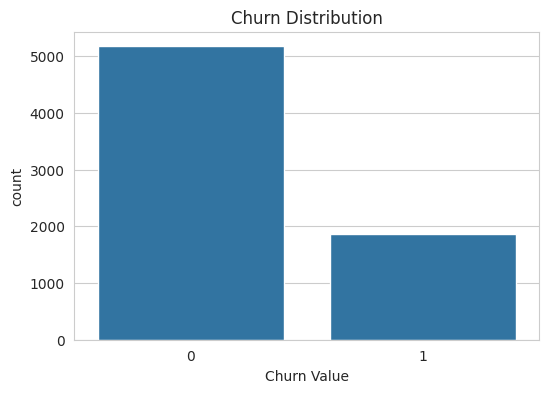

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Churn Value', data=df)
plt.title("Churn Distribution")
plt.show()

In [ ]:
X = df[final_selected_features]
y = df["Churn Value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Balancing Strategy

In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)

### Train Classical Models

In [ ]:
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
log_reg.fit(X_train_bal, y_train_bal)

rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train_bal, y_train_bal)

estimators = [
    ('lr', LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(eval_metric="logloss", random_state=42))
]
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500),
    cv=5,
    n_jobs=-1
)
stack_model.fit(X_train_bal, y_train_bal)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=500,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categoric...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(max_iter=500), n_jobs=-1)

### Hyperparameter Tuning (Random Forest)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

rf_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    rf,
    param_grid=rf_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_bal, y_train_bal)
best_rf = grid.best_estimator_
print("Best RF params:", grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best RF params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
def tune_threshold(model, X_val, y_val, thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7]):
    best_f1 = 0
    best_t = 0.5
    y_proba = model.predict_proba(X_val)[:,1]
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

best_threshold, best_f1 = tune_threshold(best_rf, X_test, y_test)
print(f"Best Threshold: {best_threshold}, Best Minority F1: {best_f1}")


Best Threshold: 0.4, Best Minority F1: 0.6486486486486487


### Neural Network Model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.680563224737714), 1: np.float64(1.8845565749235473)}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Neural Network Architecture
nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train with class weights
history = nn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight={0: 0.680563224737714, 1: 1.8845565749235473},  # your weights
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_proba_nn = nn_model.predict(X_test).ravel()

# Fine-grained threshold tuning for better precision-recall balance
best_f1 = 0
best_threshold_nn = 0.5
best_precision = 0
best_recall = 0

for t in np.arange(0.15, 0.51, 0.01):  # 0.15 to 0.5
    y_pred_temp = (y_proba_nn >= t).astype(int)
    precision = precision_score(y_test, y_pred_temp, zero_division=0)
    recall = recall_score(y_test, y_pred_temp, zero_division=0)
    f1 = f1_score(y_test, y_pred_temp, zero_division=0)

    # Pick threshold with best F1
    if f1 > best_f1:
        best_f1 = f1
        best_threshold_nn = t
        best_precision = precision
        best_recall = recall

print(f"Optimized Threshold: {best_threshold_nn:.2f}")
print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")

# Apply optimized threshold
y_pred_nn = (y_proba_nn >= best_threshold_nn).astype(int)

nn_results = {
    "Model": "Neural Network",
    "Threshold": best_threshold_nn,
    "Minority Precision": best_precision,
    "Minority Recall": best_recall,
    "Minority F1": best_f1,
    "ROC-AUC": roc_auc_score(y_test, y_proba_nn),
    "Accuracy": (y_pred_nn == y_test).mean()
}

print("\nNeural Network Evaluation (Fine-tuned Threshold)")
print(nn_results)


Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4711 - auc: 0.5387 - loss: 0.7989 - val_accuracy: 0.6653 - val_auc: 0.5702 - val_loss: 0.6307
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5309 - auc: 0.5426 - loss: 0.7229 - val_accuracy: 0.5426 - val_auc: 0.5786 - val_loss: 0.6884
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5441 - auc: 0.5643 - loss: 0.7036 - val_accuracy: 0.4615 - val_auc: 0.5700 - val_loss: 0.7451
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5529 - auc: 0.5887 - loss: 0.6898 - val_accuracy: 0.4320 - val_auc: 0.5643 - val_loss: 0.7553
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5530 - auc: 0.5561 - loss: 0.7105 - val_accuracy: 0.4290 - val_auc: 0.5338 - val_loss: 0.7357
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5416 - auc: 0.5802 - loss: 0.6870 - val_accuracy: 0.4118 - val_auc: 0.4953 - val_loss: 0.7292
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
O

### NN Evaluation with Threshold Tuning

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Best Threshold (NN): 0.3, Best Minority F1: 0.4127906976744186

Neural Network Evaluation
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1552
           1       0.35      0.51      0.41       561

    accuracy                           0.62      2113
   macro avg       0.57      0.58      0.56      2113
weighted avg       0.67      0.62      0.64      2113

ROC-AUC: 0.6043596210742966


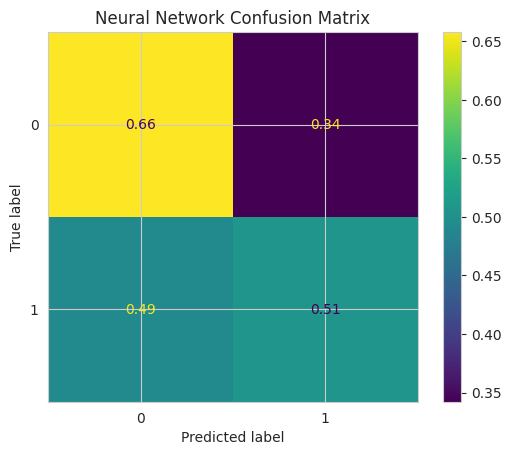

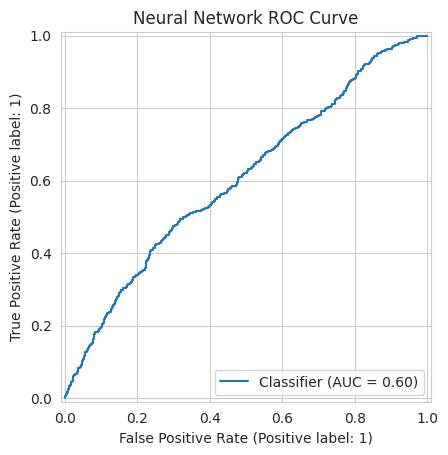

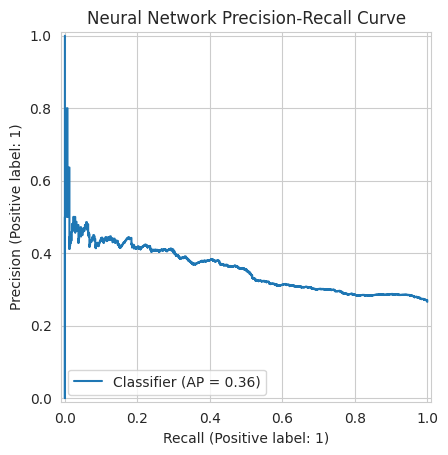

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_proba_nn = nn_model.predict(X_test).ravel()

def tune_threshold_nn(y_true, y_proba, thresholds=[0.3,0.35,0.4,0.45,0.5,0.55]):
    best_f1 = 0
    best_t = 0.5
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

best_threshold_nn, best_f1_nn = tune_threshold_nn(y_test, y_proba_nn)
print(f"Best Threshold (NN): {best_threshold_nn}, Best Minority F1: {best_f1_nn}")

y_pred_nn = (y_proba_nn >= best_threshold_nn).astype(int)

print("\nNeural Network Evaluation")
print(classification_report(y_test, y_pred_nn))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_nn))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn, normalize="true")
plt.title("Neural Network Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_nn)
plt.title("Neural Network ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_nn)
plt.title("Neural Network Precision-Recall Curve")
plt.show()

### Evaluation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(name, model, X_test, y_test, threshold=0.5):
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = (y_proba >= threshold).astype(int)

    print(f"\n{name} Evaluation (Threshold={threshold})")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()

    PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} Precision-Recall Curve")
    plt.show()

    return {
        "Model": name,
        "Threshold": threshold,
        "Minority Precision": precision_score(y_test, y_pred),
        "Minority Recall": recall_score(y_test, y_pred),
        "Minority F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": model.score(X_test, y_test)
    }

### Compare All Models


Logistic Regression Evaluation (Threshold=0.5)
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1552
           1       0.59      0.62      0.60       561

    accuracy                           0.78      2113
   macro avg       0.72      0.73      0.73      2113
weighted avg       0.79      0.78      0.79      2113

ROC-AUC: 0.8399937060109891


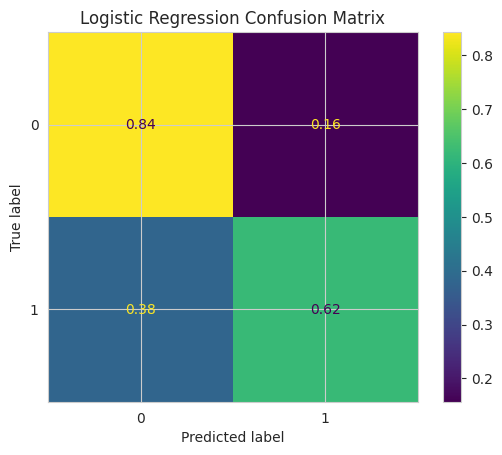

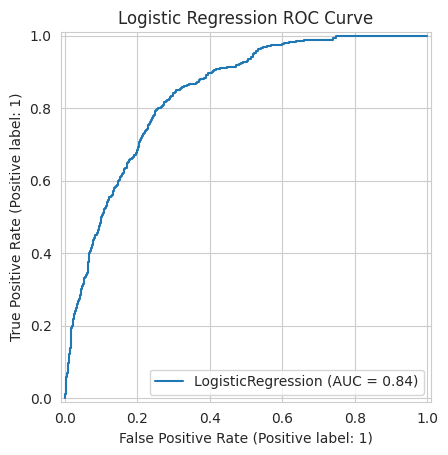

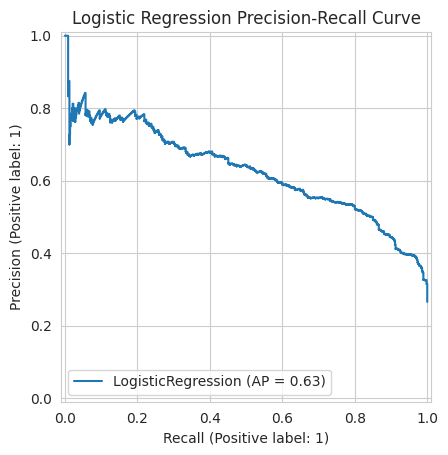

In [ ]:
# Logistic Regression
log_reg_results = evaluate_model("Logistic Regression", log_reg, X_test, y_test, threshold=0.5)


Random Forest Evaluation (Threshold=0.5)
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1552
           1       0.60      0.60      0.60       561

    accuracy                           0.79      2113
   macro avg       0.73      0.73      0.73      2113
weighted avg       0.79      0.79      0.79      2113

ROC-AUC: 0.8424768454710845


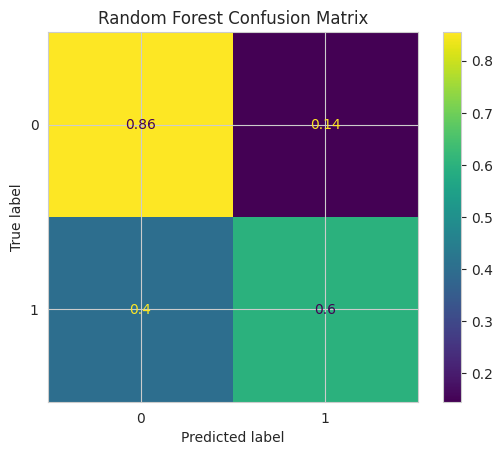

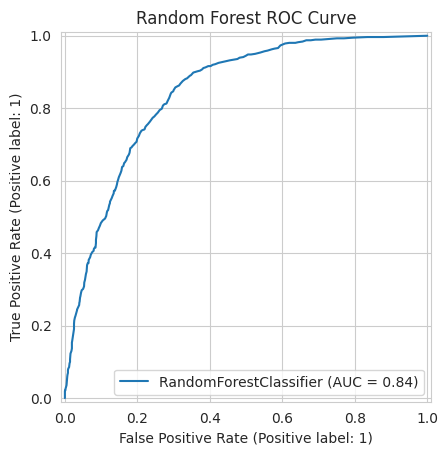

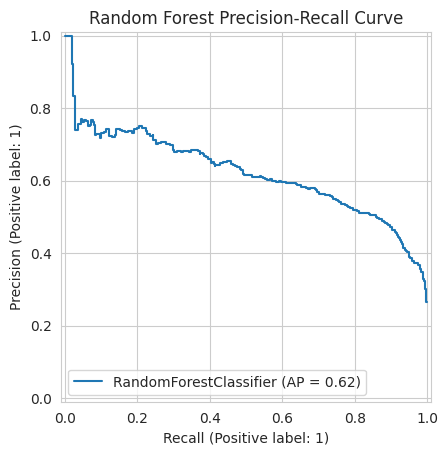

In [ ]:
# Random Forest
rf_results = evaluate_model("Random Forest", rf, X_test, y_test, threshold=0.5)



Stacking Ensemble Evaluation (Threshold=0.5)
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1552
           1       0.61      0.62      0.62       561

    accuracy                           0.79      2113
   macro avg       0.73      0.74      0.74      2113
weighted avg       0.79      0.79      0.79      2113

ROC-AUC: 0.8482367642464671


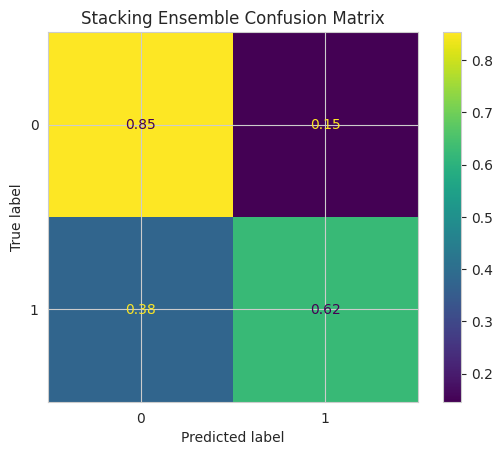

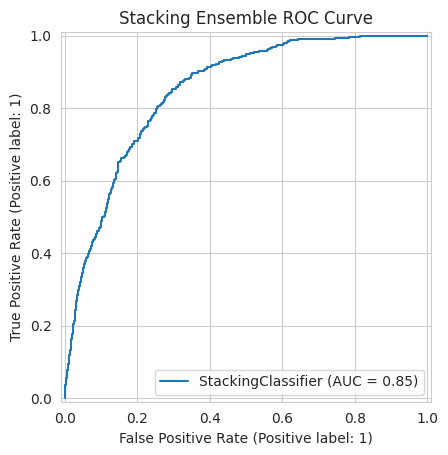

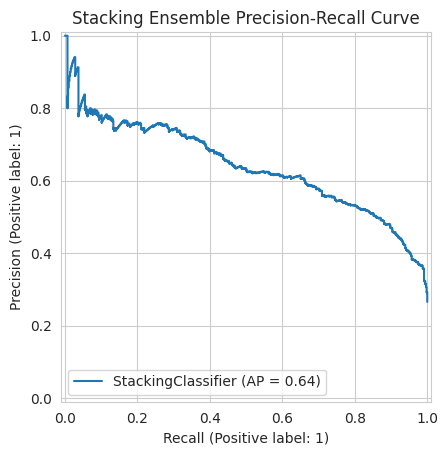

In [ ]:
# Stacking Ensemble
stack_results = evaluate_model("Stacking Ensemble", stack_model, X_test, y_test, threshold=0.5)


In [ ]:
# Neural Network
nn_results = {
    "Model": "Neural Network",
    "Threshold": best_threshold_nn,
    "Minority Precision": precision_score(y_test, y_pred_nn),
    "Minority Recall": recall_score(y_test, y_pred_nn),
    "Minority F1": f1_score(y_test, y_pred_nn),
    "ROC-AUC": roc_auc_score(y_test, y_proba_nn),
    "Accuracy": (y_pred_nn == y_test).mean()
}
print("\nNeural Network Evaluation")
print(nn_results)


Neural Network Evaluation
{'Model': 'Neural Network', 'Threshold': 0.3, 'Minority Precision': 0.34846625766871164, 'Minority Recall': 0.5062388591800356, 'Minority F1': 0.4127906976744186, 'ROC-AUC': np.float64(0.6043596210742966), 'Accuracy': np.float64(0.6176053005205868)}


In [ ]:
# Model Comparison DataFrame
results_df = pd.DataFrame([
    log_reg_results,
    rf_results,
    stack_results,
    nn_results
])

print("\nModel Comparison (SMOTE + Tomek Links + NN):\n", results_df)



Model Comparison (SMOTE + Tomek Links + NN):
                  Model  Threshold  Minority Precision  Minority Recall  \
0  Logistic Regression        0.5            0.588136         0.618538   
1        Random Forest        0.5            0.598214         0.597148   
2    Stacking Ensemble        0.5            0.606586         0.623886   
3       Neural Network        0.3            0.348466         0.506239   

   Minority F1   ROC-AUC  Accuracy  
0     0.602954  0.839994  0.783720  
1     0.597681  0.842477  0.785613  
2     0.615114  0.848237  0.792712  
3     0.412791  0.604360  0.617605  



Logistic Regression Evaluation (Threshold=0.5)
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1552
           1       0.59      0.62      0.60       561

    accuracy                           0.78      2113
   macro avg       0.72      0.73      0.73      2113
weighted avg       0.79      0.78      0.79      2113

ROC-AUC: 0.8399937060109891


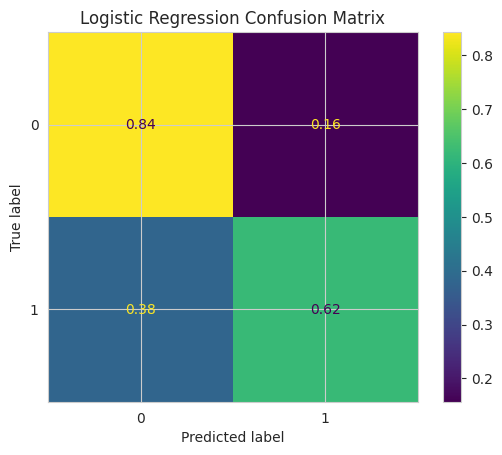

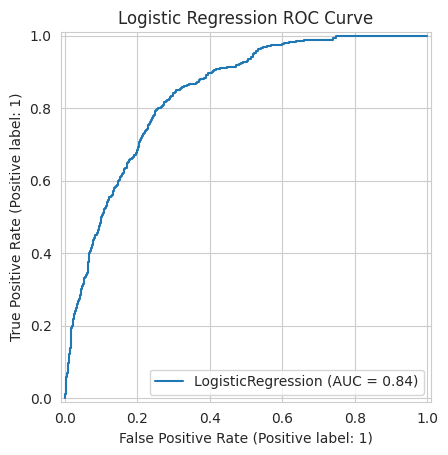

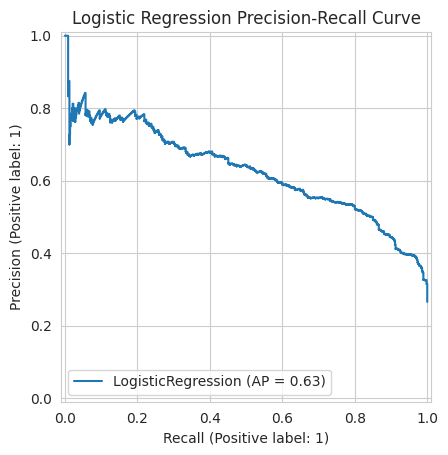


Random Forest Evaluation (Threshold=0.5)
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1552
           1       0.60      0.60      0.60       561

    accuracy                           0.79      2113
   macro avg       0.73      0.73      0.73      2113
weighted avg       0.79      0.79      0.79      2113

ROC-AUC: 0.8424768454710845


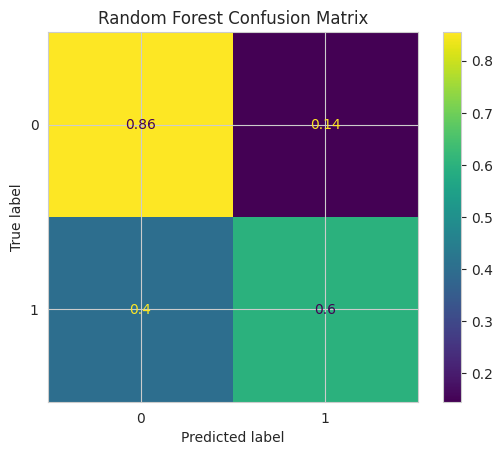

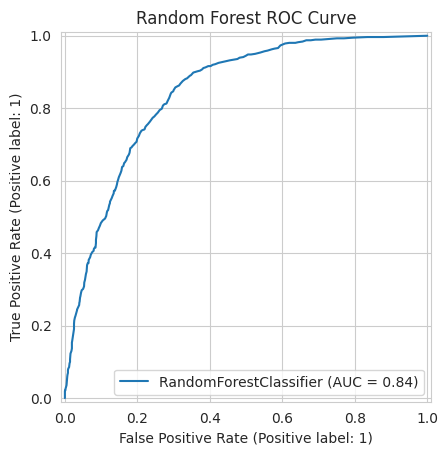

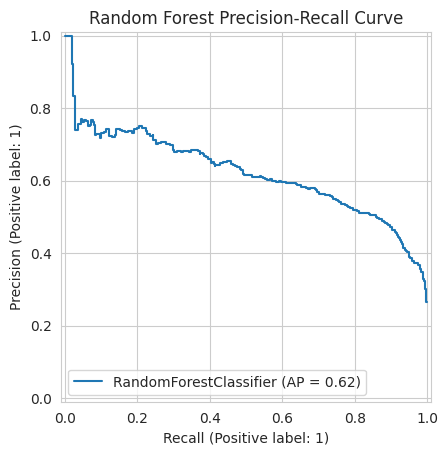


Stacking Ensemble Evaluation (Threshold=0.5)
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1552
           1       0.61      0.62      0.62       561

    accuracy                           0.79      2113
   macro avg       0.73      0.74      0.74      2113
weighted avg       0.79      0.79      0.79      2113

ROC-AUC: 0.8482367642464671


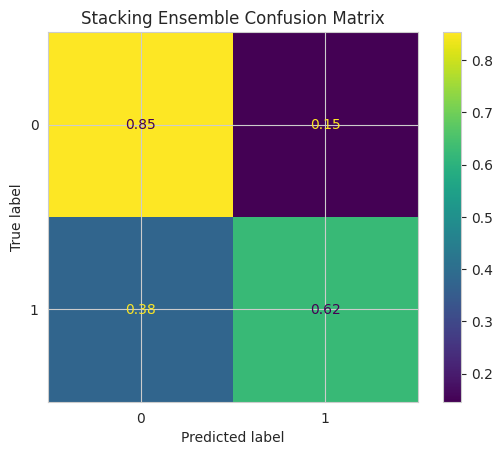

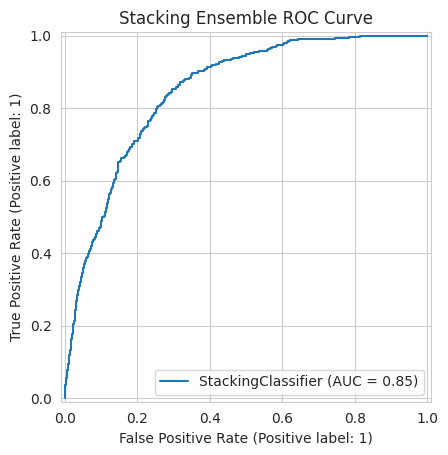

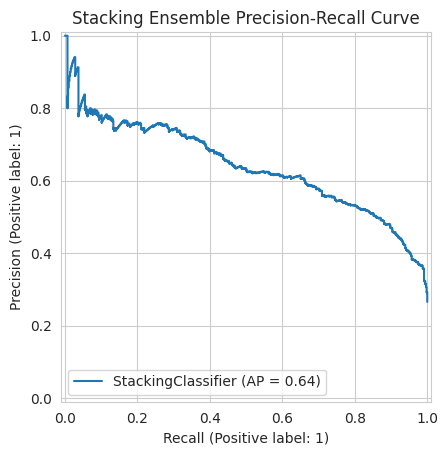


Model Comparison (SMOTE + Tomek Links + NN):
                  Model  Threshold  Minority Precision  Minority Recall  \
0  Logistic Regression        0.5            0.588136         0.618538   
1        Random Forest        0.5            0.598214         0.597148   
2    Stacking Ensemble        0.5            0.606586         0.623886   
3       Neural Network        0.3            0.348466         0.506239   

   Minority F1   ROC-AUC  Accuracy  
0     0.602954  0.839994  0.783720  
1     0.597681  0.842477  0.785613  
2     0.615114  0.848237  0.792712  
3     0.412791  0.604360  0.617605  


In [ ]:
results = []
for model_name, model in [("Logistic Regression", log_reg),
                          ("Random Forest", rf),
                          ("Stacking Ensemble", stack_model)]:
    results.append(evaluate_model(model_name, model, X_test, y_test, threshold=0.5))

# Add NN results
results.append({
    "Model": "Neural Network",
    "Threshold": best_threshold_nn,
    "Minority Precision": precision_score(y_test, y_pred_nn),
    "Minority Recall": recall_score(y_test, y_pred_nn),
    "Minority F1": f1_score(y_test, y_pred_nn),
    "ROC-AUC": roc_auc_score(y_test, y_proba_nn),
    "Accuracy": (y_pred_nn == y_test).mean()
})

results_df = pd.DataFrame(results)
print("\nModel Comparison (SMOTE + Tomek Links + NN):\n", results_df)

## Saving Model

In [ ]:
import joblib

# Save models
joblib.dump(log_reg, "logistic_regression_model.pkl")
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(stack_model, "stacking_ensemble_model.pkl")
joblib.dump(nn_model, "neural_network_model.pkl")

['neural_network_model.pkl']